In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

In [ ]:
BATCH_SIZE = 32
ROOT_PATH = '/content/drive/MyDrive/Colab Notebooks'
PROJ_PATH = os.path.join(ROOT_PATH, 'PyTorch')
DATA_PATH = os.path.join(ROOT_PATH, 'data/cats_and_dogs')
MODEL_ROOT_PATH = os.path.join(PROJ_PATH, 'model')

TRAIN_DATA_PATH = os.path.join(DATA_PATH, 'train')
TEST_DATA_PATH = os.path.join(DATA_PATH, 'validation')

In [ ]:
transform = transforms.Compose([
                          transforms.Resize((256,256)),
                          transforms.ToTensor()
                        ])

trainset = torchvision.datasets.ImageFolder(root=TRAIN_DATA_PATH, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

testset = torchvision.datasets.ImageFolder(root=TRAIN_DATA_PATH, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

In [ ]:
model = nn.Sequential(
          nn.Conv2d(3,32,3),
          nn.LeakyReLU(),
          nn.MaxPool2d(4),
          nn.Conv2d(32,64,3),
          nn.LeakyReLU(),
          nn.MaxPool2d(4),
          nn.Conv2d(64,128,3),
          nn.LeakyReLU(),
          nn.MaxPool2d(4),
          nn.Flatten(),          
          nn.Linear(1152, 128),
          nn.LeakyReLU(),
          nn.Linear(128, 64),
          nn.LeakyReLU(),
          nn.Linear(64, 1),
          nn.Sigmoid()
        )

Image label dimensions: torch.Size([32])
Image batch dimensions: torch.Size([32, 3, 256, 256])
Model output dimensions: torch.Size([32, 1])
tensor([1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1,
        0, 0, 0, 1, 1, 1, 0, 0])


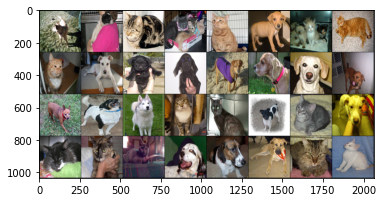

In [ ]:
## functions to show an image
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

## get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

print("Image label dimensions:", labels.shape)
print("Image batch dimensions:", images.shape)

out = model(images)
# print("Model output:", out)
print("Model output dimensions:", out.shape)

## show images
print(labels)
imshow(torchvision.utils.make_grid(images))

In [ ]:
MODEL_LOAD_PATH = os.path.join(MODEL_ROOT_PATH, 'cats_dogs_classifier_05')
model.load_state_dict(torch.load(MODEL_LOAD_PATH))

In [ ]:
learning_rate = 0.001
num_epochs = 5

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
## compute accuracy
def get_accuracy(logit, target, batch_size):
    ''' Obtain accuracy for training round '''
    corrects = (torch.round(logit).data == target.data).sum()
    accuracy = 100.0 * corrects/batch_size
    return accuracy.item()

In [ ]:
MODEL_SAVE_PATH = os.path.join(MODEL_ROOT_PATH, 'cats_dogs_classifier_20')

for epoch in range(num_epochs):
    train_running_loss = 0.0
    train_acc = 0.0

    model = model.train()

    ## training step
    for i, (images, labels) in enumerate(trainloader):
        
        images = images.to(device)
        labels = labels.to(device).to(torch.float32)

        ## forward + backprop + loss
        logits = model(images).view(labels.size()).to(torch.float32)
        loss = criterion(logits, labels)
        optimizer.zero_grad()
        loss.backward()

        ## update model params
        optimizer.step()

        train_running_loss += loss.detach().item()
        train_acc += get_accuracy(logits, labels, BATCH_SIZE)
    
    model.eval()
    print('Epoch: %d | Loss: %.4f | Train Accuracy: %.2f' \
          %(epoch, train_running_loss / i, train_acc/i))        

torch.save(model.state_dict(), MODEL_SAVE_PATH)

Epoch: 0 | Loss: 0.2148 | Train Accuracy: 91.99
Epoch: 1 | Loss: 0.1702 | Train Accuracy: 94.66
Epoch: 2 | Loss: 0.1311 | Train Accuracy: 96.07
Epoch: 3 | Loss: 0.0966 | Train Accuracy: 97.58
Epoch: 4 | Loss: 0.0458 | Train Accuracy: 99.34
